In [1]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np
import pandas as pd

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import load_img, img_to_array

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

# ANÁLISIS EXPLORATORIO SOBRE EL CONJUNTO DE DATOS

## Volumetría de datos

Train: 8005 imagenes
- Perros: 4005
- Gatos: 4000

Test: 2023 imagenes
- Perros: 1012
- Gatos: 1011

En ambos dataset los datos se encuentran **balanceados**, ya que en proporción existe casi la misma cantidad para ambas clases.

## Estructura y tipo de las imagenes

Nombre imagen: dog.3858.jpg
Dimensiones de la imagen:
(209, 225, 3)


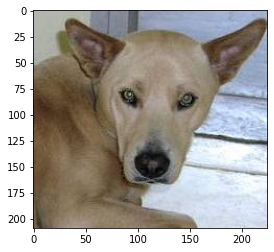

Nombre imagen: cat.246.jpg
Dimensiones de la imagen:
(375, 499, 3)


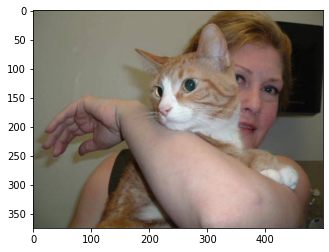

Nombre imagen: dog.350.jpg
Dimensiones de la imagen:
(191, 199, 3)


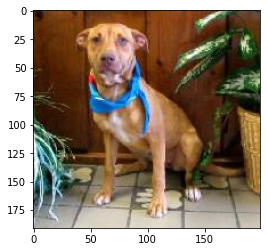

Nombre imagen: cat.1525.jpg
Dimensiones de la imagen:
(374, 500, 3)


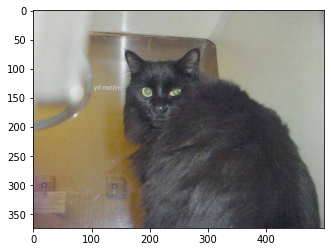

Nombre imagen: dog.165.jpg
Dimensiones de la imagen:
(375, 500, 3)


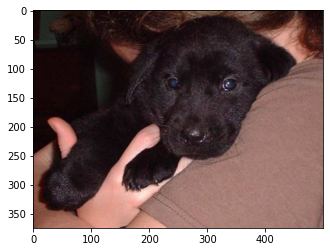

Nombre imagen: cat.2659.jpg
Dimensiones de la imagen:
(374, 307, 3)


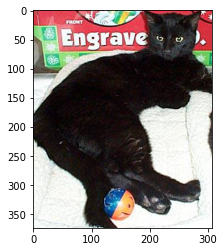

In [2]:
from skimage import io
from random import randint

for x in range(3):
    
    nro_imagen_dog = randint(0,4000)
    nro_imagen_cat = randint(0,4000)
    image_dog=io.imread("./imagenes_tp3_cv/training_set/training_set/dogs/dog.{}.jpg".format(nro_imagen_dog))
    image_cat=io.imread("./imagenes_tp3_cv/training_set/training_set/cats/cat.{}.jpg".format(nro_imagen_cat))

    print("Nombre imagen: dog."+ str(nro_imagen_dog) + ".jpg")
    print("Dimensiones de la imagen:")
    print(image_dog.shape)
    plt.imshow(image_dog)
    plt.show()
    
    print("Nombre imagen: cat."+ str(nro_imagen_cat) + ".jpg")
    print("Dimensiones de la imagen:")
    print(image_cat.shape)
    plt.imshow(image_cat)
    
    plt.show()

## Armado del Dataset

Como vemos en los ejemplos, las imagenes son de distintos tamaños, por lo que las redimensionaremos a 64 x 64 y trabajaremos con 3 colores (RGB).

In [3]:
animales = "cats", "dogs"

# Directorio de imágenes
TRAIN_DIR = Path('./imagenes_tp3_cv/training_set/training_set')
TEST_DIR = Path('./imagenes_tp3_cv/test_set/test_set')

In [4]:
train = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",  # adivinar los labels en base al nombre del sub directorio
    label_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    class_names=animales,  # para usar el mismo orden en todos lados
    color_mode="rgb",  # queremos trabajar con las imágenes a color
    image_size=(64, 64),  # para que corra más rápido, vamos a achicar las imágenes
    shuffle=True,  # que recorra el set de imágenes en orden aleatorio
    seed=47,  # semilla para que la aleatoriedad sea repetible
)

Found 8005 files belonging to 2 classes.


In [5]:
test = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=animales,
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=True,
    seed=47,
)

Found 2023 files belonging to 2 classes.


In [6]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(animales[np.argmax(labels[i])])
            plt.axis("off")

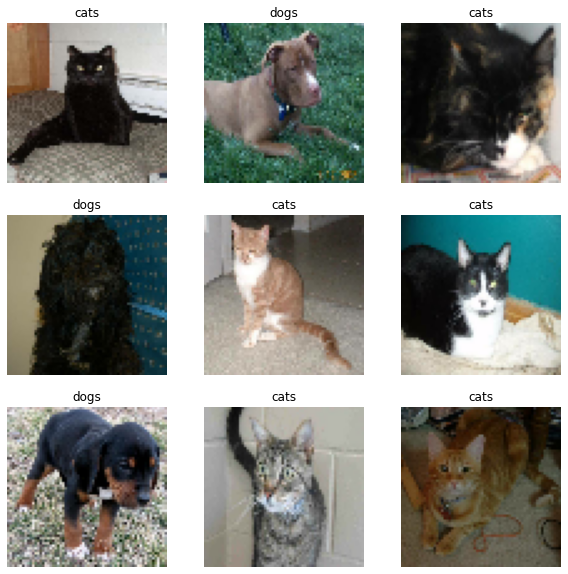

In [7]:
sample_images(train)

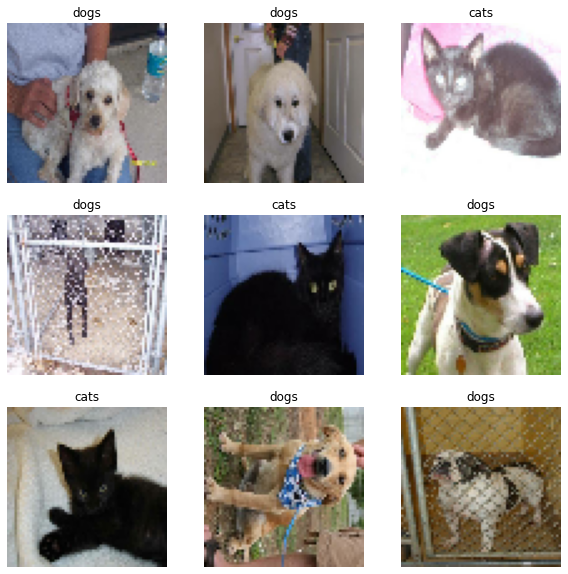

In [8]:
sample_images(test)

# MACHINE LEARNING

## Funciones útiles

In [9]:
# Función para predecir

from IPython.display import Image, display

def show_and_predict(model,image_path):
    image_array = img_to_array(load_img(image_path, target_size=(64, 64)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model.predict(inputs)
    display(Image(image_path, width=300))
    print("Prediction:", animales[np.argmax(predictions)])
    print("Prediction detail:", predictions)

In [10]:
# Función que dibuja la matriz de confusión
def matriz(model):
    
    datasets = (
        ("train", train),
        ("test", test),   
    )

    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)

        # el dataset se itera en batches, así que calculamos predicciones y labels por cada batch, y luego 
        # concatenamos todo
        batches_predictions = []
        batches_labels =  []

        for batch_images, batch_labels in dataset:
            # super importante: usamos argmax para convertir cosas de este formato:
            # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
            # a este formato (donde tenemos el índice de la clase que tiene número más alto):
            # [1, 0, 0, 2]
            batches_predictions.append(np.argmax(model.predict(batch_images), axis=-1))
            batches_labels.append(np.argmax(batch_labels, axis=-1))

        predictions = np.concatenate(batches_predictions)
        labels = np.concatenate(batches_labels)

        print('accuracy', accuracy_score(labels, predictions))

        # graficamos la confussion matrix
        plt.figure(figsize=(3, 4))

        plt.xticks([0, 1], animales, rotation=45)
        plt.yticks([0, 1], animales)
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.imshow(
            confusion_matrix(labels, predictions), 
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )

        plt.show()

In [11]:
# Función que dibuja las curvas
def curvas(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Accuracy over train epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [12]:
# Función para mostrar ejemplos de predicciones

from skimage import io
from random import randint

def predecir (cantidad,model):
    
    for x in range(cantidad):
    
        nro_imagen_dog = randint(0,4000)
        nro_imagen_cat = randint(0,4000)
        image_dog=io.imread("./imagenes_tp3_cv/training_set/training_set/dogs/dog.{}.jpg".format(nro_imagen_dog))
        image_cat=io.imread("./imagenes_tp3_cv/training_set/training_set/cats/cat.{}.jpg".format(nro_imagen_cat))

        print("Nombre imagen: dog."+ str(nro_imagen_dog) + ".jpg")
        #print("Predicción:")
        show_and_predict(model,"./imagenes_tp3_cv/training_set/training_set/dogs/dog.{}.jpg".format(nro_imagen_dog))
        # plt.imshow(image_dog)
        # plt.show()
        
        print ()
        print ()
        
        print("Nombre imagen: cat."+ str(nro_imagen_cat) + ".jpg")
        #print("Predicción:")
        show_and_predict(model,"./imagenes_tp3_cv/training_set/training_set/cats/cat.{}.jpg".format(nro_imagen_cat))
        # plt.imshow(image_cat)
    
        # plt.show()
        print ()
        print ()

## Modelos

### MLP 1

In [13]:
model_mlp_1 = Sequential([
    
    Rescaling(1/255, input_shape=(64, 64, 3)), # normalizar las entradas de los datasets
  
    Dense(20, activation='relu'),
    Dropout(0.4),
    
    Flatten(),
    
    Dense(20, activation='relu'),
    Dropout(0.1),
    
    Dense(20, activation='relu'),

    Dense(20, activation='relu'),
    Dropout(0.2),
    
    Dense(20, activation='relu'),
    
    Dense(20, activation='relu'),
    Dropout(0.1),
    
    Dense(20, activation='relu'),
    
    Dense(20, activation='relu'),
    Dropout(0.2),
    
    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_mlp_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [14]:
model_mlp_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
dense (Dense)                (None, 64, 64, 20)        80        
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 81920)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1638420   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                4

In [15]:
history_mlp_1 = model_mlp_1.fit(
    train,
    epochs=10,
    batch_size=50, # Ajusta los pesos cada x imagenes
    validation_data=test,
)

Epoch 1/10
251/251 [==============================] - 83s 320ms/step - loss: 0.6975 - accuracy: 0.4971 - val_loss: 0.6896 - val_accuracy: 0.5482
Epoch 2/10
251/251 [==============================] - 71s 283ms/step - loss: 0.6933 - accuracy: 0.4942 - val_loss: 0.6925 - val_accuracy: 0.5077
Epoch 3/10
251/251 [==============================] - 63s 248ms/step - loss: 0.6916 - accuracy: 0.5082 - val_loss: 0.6899 - val_accuracy: 0.5344
Epoch 4/10
251/251 [==============================] - 92s 367ms/step - loss: 0.6840 - accuracy: 0.5544 - val_loss: 0.6698 - val_accuracy: 0.5907
Epoch 5/10
251/251 [==============================] - 74s 295ms/step - loss: 0.6703 - accuracy: 0.5943 - val_loss: 0.6397 - val_accuracy: 0.6476
Epoch 6/10
251/251 [==============================] - 66s 259ms/step - loss: 0.6482 - accuracy: 0.6403 - val_loss: 0.6409 - val_accuracy: 0.6560
Epoch 7/10
251/251 [==============================] - 71s 281ms/step - loss: 0.6439 - accuracy: 0.6459 - val_loss: 0.6295 - val_ac

######################### train #########################
accuracy 0.7121798875702686


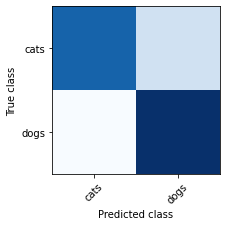

######################### test #########################
accuracy 0.671774592189817


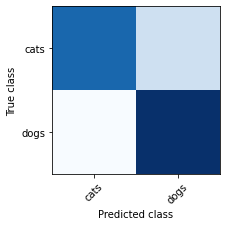

In [16]:
matriz(model_mlp_1)

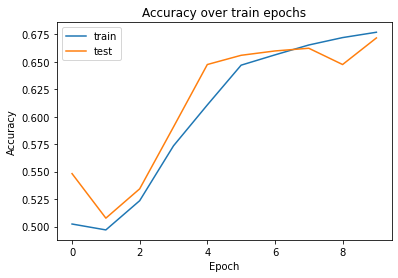

In [17]:
curvas(history_mlp_1)

Para el primer modelo MLP que construimos podemos observar que obtuvimos un **71 %** de accuracy en **train** y un **67 %** en **test**.
Además, observando la matriz de confusión podemos concluir que la **mayor cantidad de predicciones acertadas** es en la clase **perros**.

Algunas predicciones:

Nombre imagen: dog.1970.jpg


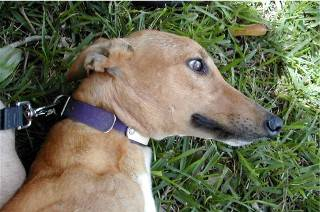

Prediction: dogs
Prediction detail: [[0.32831928 0.6716807 ]]


Nombre imagen: cat.1848.jpg


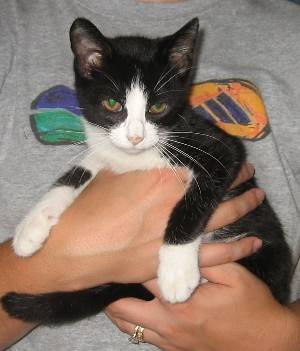

Prediction: dogs
Prediction detail: [[0.3282352 0.6717648]]


Nombre imagen: dog.2699.jpg


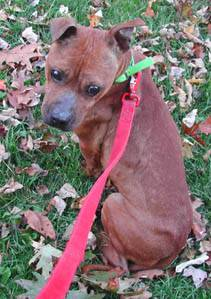

Prediction: dogs
Prediction detail: [[0.3282352 0.6717648]]


Nombre imagen: cat.309.jpg


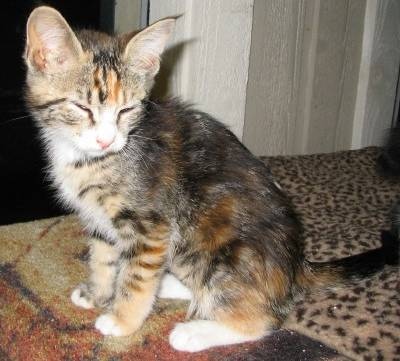

Prediction: cats
Prediction detail: [[0.6147218 0.3852782]]




In [18]:
predecir(2,model_mlp_1)

### MLP 2

In [19]:
model_mlp_2 = Sequential([
    
    Rescaling(1/255, input_shape=(64, 64, 3)), # normalizar las entradas de los datasets
  
    Dense(20, activation='relu'),
    
    Flatten(),
    
    Dense(20, activation='relu'),

    Dense(20, activation='relu'),
    Dropout(0.2),

    Dense(20, activation='relu'),
    
    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_mlp_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [20]:
model_mlp_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
dense_9 (Dense)              (None, 64, 64, 20)        80        
_________________________________________________________________
flatten_1 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                1638420   
_________________________________________________________________
dense_11 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)               

In [21]:
history_mlp_2 = model_mlp_2.fit(
    train,
    epochs=10,
    batch_size=50, # Ajusta los pesos cada x imagenes
    validation_data=test,
)

Epoch 1/10
251/251 [==============================] - 56s 215ms/step - loss: 0.7723 - accuracy: 0.5192 - val_loss: 0.6608 - val_accuracy: 0.5991
Epoch 2/10
251/251 [==============================] - 49s 195ms/step - loss: 0.6715 - accuracy: 0.5867 - val_loss: 0.6347 - val_accuracy: 0.6367
Epoch 3/10
251/251 [==============================] - 53s 211ms/step - loss: 0.6361 - accuracy: 0.6379 - val_loss: 0.6195 - val_accuracy: 0.6629
Epoch 4/10
251/251 [==============================] - 50s 199ms/step - loss: 0.6081 - accuracy: 0.6668 - val_loss: 0.6342 - val_accuracy: 0.6747
Epoch 5/10
251/251 [==============================] - 49s 193ms/step - loss: 0.5840 - accuracy: 0.6830 - val_loss: 0.6095 - val_accuracy: 0.6777
Epoch 6/10
251/251 [==============================] - 62s 244ms/step - loss: 0.5586 - accuracy: 0.7128 - val_loss: 0.6022 - val_accuracy: 0.6980
Epoch 7/10
251/251 [==============================] - 52s 206ms/step - loss: 0.5406 - accuracy: 0.7197 - val_loss: 0.5952 - val_ac

######################### train #########################
accuracy 0.7967520299812617


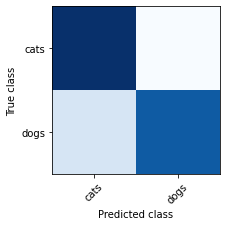

######################### test #########################
accuracy 0.6925358378645576


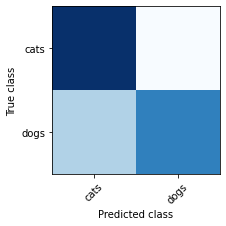

In [22]:
matriz(model_mlp_2)

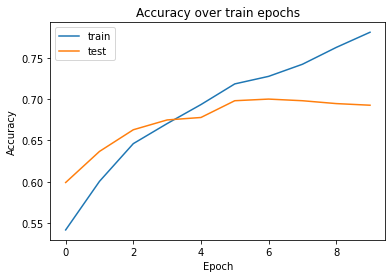

In [23]:
curvas(history_mlp_2)

Para el segundo modelo MLP podemos observar que obtuvimos mejores resultados con **79 %** de accuracy en **train** y un **69 %** en **test**.
A diferencia del modelo anterior la **mayor cantidad de predicciones acertadas** es en la clase **gatos**.

Algunas predicciones:

Nombre imagen: dog.1701.jpg


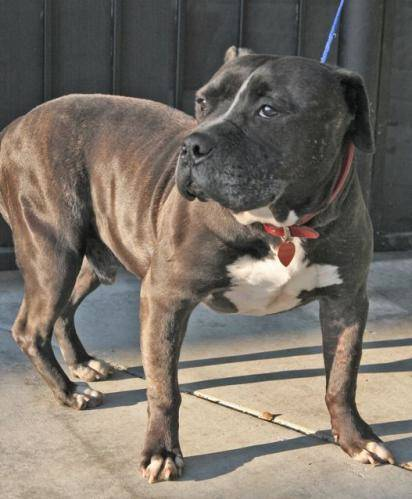

Prediction: dogs
Prediction detail: [[0.3738934  0.62610656]]


Nombre imagen: cat.3455.jpg


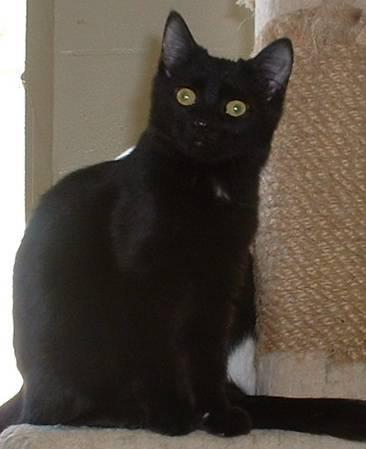

Prediction: cats
Prediction detail: [[0.9851966  0.01480339]]


Nombre imagen: dog.2945.jpg


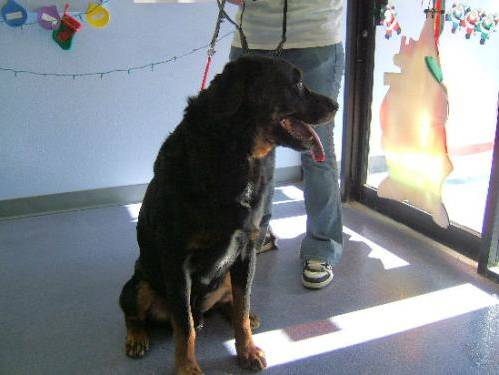

Prediction: dogs
Prediction detail: [[0.13056271 0.8694373 ]]


Nombre imagen: cat.455.jpg


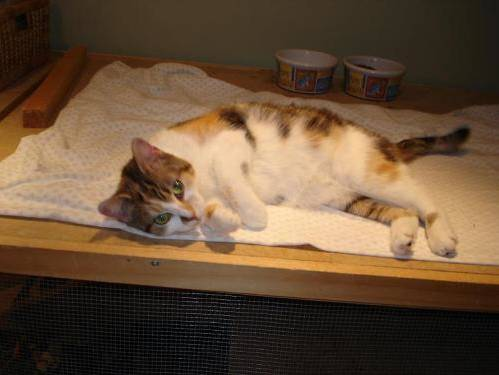

Prediction: cats
Prediction detail: [[0.5163777  0.48362234]]




In [24]:
predecir(2,model_mlp_2)

### CONVOLUCIONAL 1

In [25]:
model_cnn1 = Sequential([

    Rescaling(1/255, input_shape=(64, 64, 3)), # normalizar las entradas de los datasets

    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x3, y salida de 61x61x8
    Dropout(0.2),
    
    MaxPooling2D(pool_size=(4, 4)),
    # salida de 30x30x8
    
    Flatten(),
    # salida de 7200
    
    Dense(10, activation='tanh'),
    # salida de 10
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),

    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_cnn1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [26]:
model_cnn1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 61, 61, 8)         392       
_________________________________________________________________
dropout_6 (Dropout)          (None, 61, 61, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                18010     
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

In [27]:
history_cnn1 = model_cnn1.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=test,
)

Epoch 1/5
251/251 [==============================] - 83s 321ms/step - loss: 0.7137 - accuracy: 0.5646 - val_loss: 0.6133 - val_accuracy: 0.6742
Epoch 2/5
251/251 [==============================] - 65s 256ms/step - loss: 0.6086 - accuracy: 0.6782 - val_loss: 0.6007 - val_accuracy: 0.6713
Epoch 3/5
251/251 [==============================] - 64s 255ms/step - loss: 0.5676 - accuracy: 0.7075 - val_loss: 0.5949 - val_accuracy: 0.6881
Epoch 4/5
251/251 [==============================] - 66s 261ms/step - loss: 0.5399 - accuracy: 0.7388 - val_loss: 0.6179 - val_accuracy: 0.6777
Epoch 5/5
251/251 [==============================] - 66s 260ms/step - loss: 0.5221 - accuracy: 0.7462 - val_loss: 0.5432 - val_accuracy: 0.7207


######################### train #########################
accuracy 0.7918800749531543


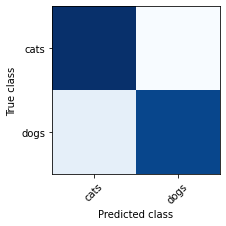

######################### test #########################
accuracy 0.7207118141374197


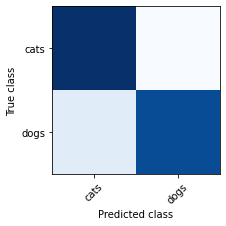

In [28]:
matriz(model_cnn1)

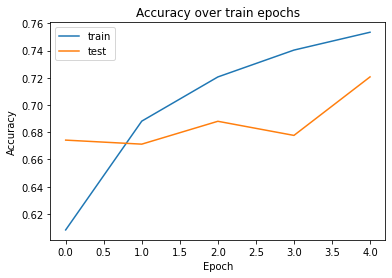

In [29]:
curvas(history_cnn1)

Para el primer modelo CNN podemos observar que obtuvimos **79 %** de accuracy en **train** y un **72 %** en **test**.

Algunas predicciones:

Nombre imagen: dog.3869.jpg


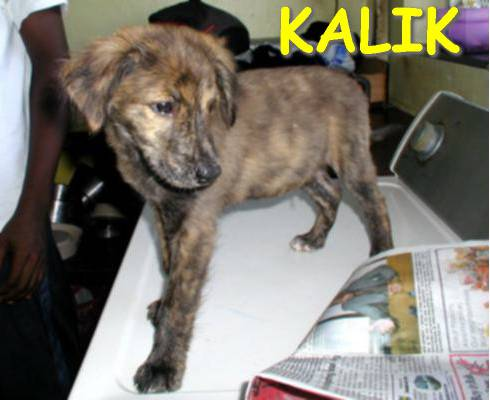

Prediction: dogs
Prediction detail: [[0.36677146 0.63322854]]


Nombre imagen: cat.3031.jpg


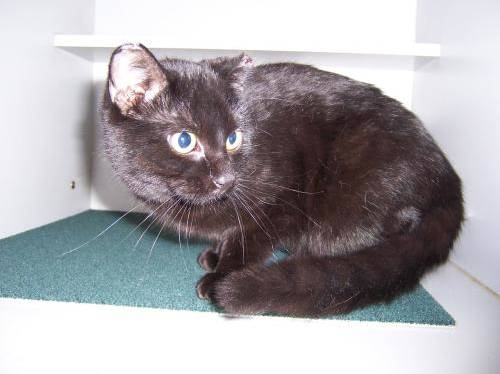

Prediction: cats
Prediction detail: [[0.85944027 0.14055972]]


Nombre imagen: dog.891.jpg


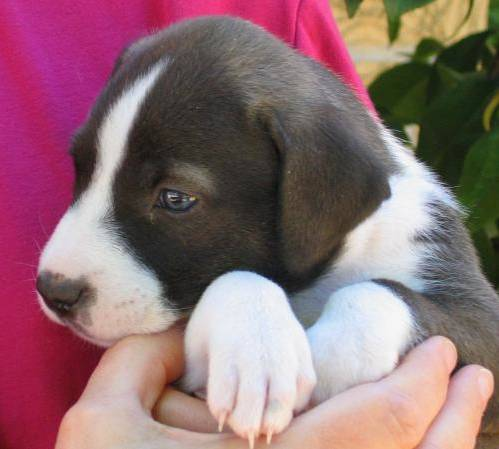

Prediction: cats
Prediction detail: [[0.5805305 0.4194695]]


Nombre imagen: cat.1300.jpg


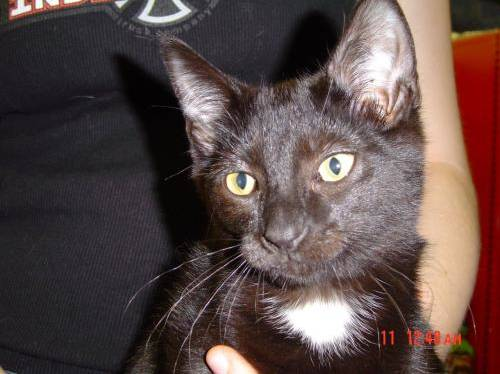

Prediction: cats
Prediction detail: [[0.6482929  0.35170707]]




In [30]:
predecir(2,model_cnn1)

### CONVOLUCIONAL 2

In [39]:
model_cnn2 = Sequential([

    Rescaling(1/255, input_shape=(64, 64, 3)), # normalizar las entradas de los datasets

    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='tanh'),
    # kernels de 4x4x3, y salida de 61x61x8
    Dropout(0.1),
    
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x8, y salida de 58x58x8
    Dropout(0.1),
    
    MaxPooling2D(pool_size=(4, 4)),
    # salida de 30x30x8
    
    Flatten(),
    # salida de 7200
    
    Dense(15, activation='relu'),
    # salida de 10
    Dropout(0.2),
    
    Dense(15, activation='tanh'),
    # salida de 10
    Dropout(0.2),

    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_cnn2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [40]:
model_cnn2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 8)         392       
_________________________________________________________________
dropout_8 (Dropout)          (None, 61, 61, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 8)         1032      
_________________________________________________________________
dropout_9 (Dropout)          (None, 58, 58, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)             

In [41]:
history_cnn2 = model_cnn2.fit(
    train,
    epochs=10,
    batch_size=128,
    validation_data=test,
)

Epoch 1/10
251/251 [==============================] - 251s 973ms/step - loss: 0.7076 - accuracy: 0.5047 - val_loss: 0.6824 - val_accuracy: 0.5744
Epoch 2/10
251/251 [==============================] - 116s 461ms/step - loss: 0.6762 - accuracy: 0.5639 - val_loss: 0.6498 - val_accuracy: 0.6243
Epoch 3/10
251/251 [==============================] - 115s 458ms/step - loss: 0.6379 - accuracy: 0.6264 - val_loss: 0.5934 - val_accuracy: 0.6970
Epoch 4/10
251/251 [==============================] - 112s 446ms/step - loss: 0.6042 - accuracy: 0.6564 - val_loss: 0.5656 - val_accuracy: 0.7123
Epoch 5/10
251/251 [==============================] - 116s 461ms/step - loss: 0.5720 - accuracy: 0.6931 - val_loss: 0.5604 - val_accuracy: 0.7024
Epoch 6/10
251/251 [==============================] - 117s 465ms/step - loss: 0.5421 - accuracy: 0.7192 - val_loss: 0.5388 - val_accuracy: 0.7336
Epoch 7/10
251/251 [==============================] - 120s 476ms/step - loss: 0.5029 - accuracy: 0.7502 - val_loss: 0.5374 -

######################### train #########################
accuracy 0.8309806371018114


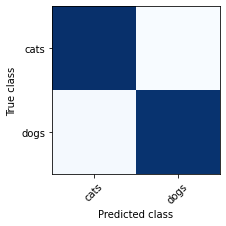

######################### test #########################
accuracy 0.7449332674246169


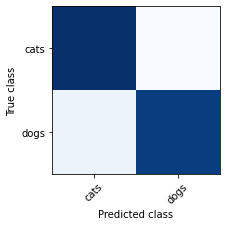

In [42]:
matriz(model_cnn2)

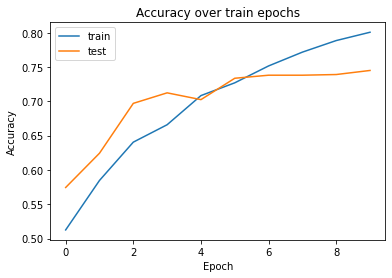

In [43]:
curvas(history_cnn2)

Para el segundo modelo CNN podemos observar que obtuvimos **83 %** de accuracy en **train** y un **74 %** en **test**.

Algunas predicciones:

Nombre imagen: dog.1596.jpg


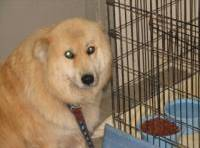

Prediction: dogs
Prediction detail: [[0.08716967 0.91283035]]


Nombre imagen: cat.3167.jpg


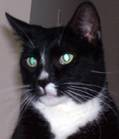

Prediction: cats
Prediction detail: [[0.9570551 0.0429449]]


Nombre imagen: dog.1507.jpg


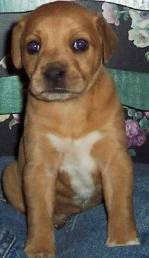

Prediction: dogs
Prediction detail: [[0.48863342 0.51136655]]


Nombre imagen: cat.2594.jpg


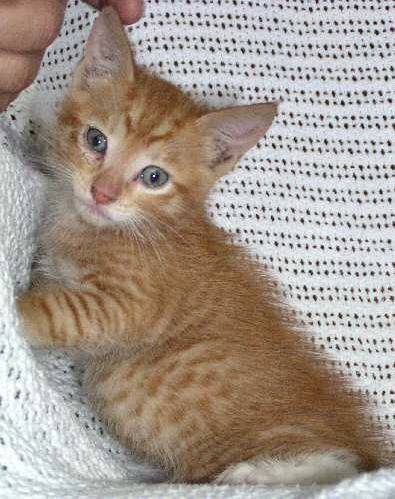

Prediction: cats
Prediction detail: [[0.54101986 0.45898014]]




In [45]:
predecir(2,model_cnn2)

# CONCLUSIÓN

### MLP 

El mejor modelo que construimos de MLP es el **model_mlp_2** donde obtuvimos un 69 % en test.
A continuación realizamos predicciones sobre nuevos casos:

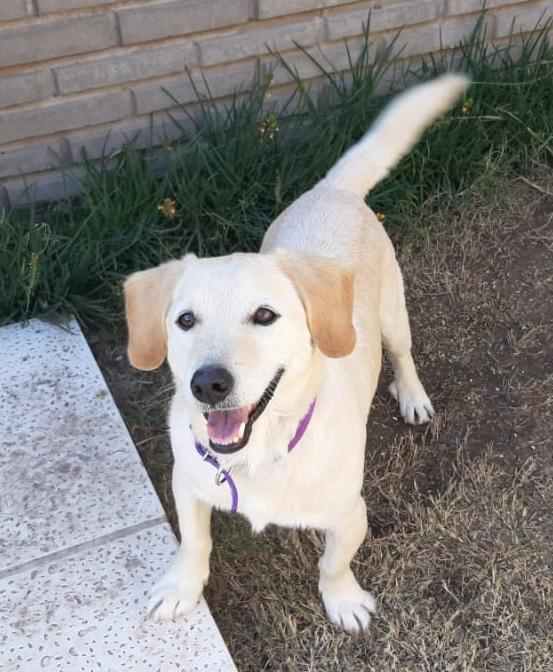

Prediction: cats
Prediction detail: [[0.86581564 0.13418438]]


In [31]:
show_and_predict(model_mlp_2,"./Fotos/beto.jpg")

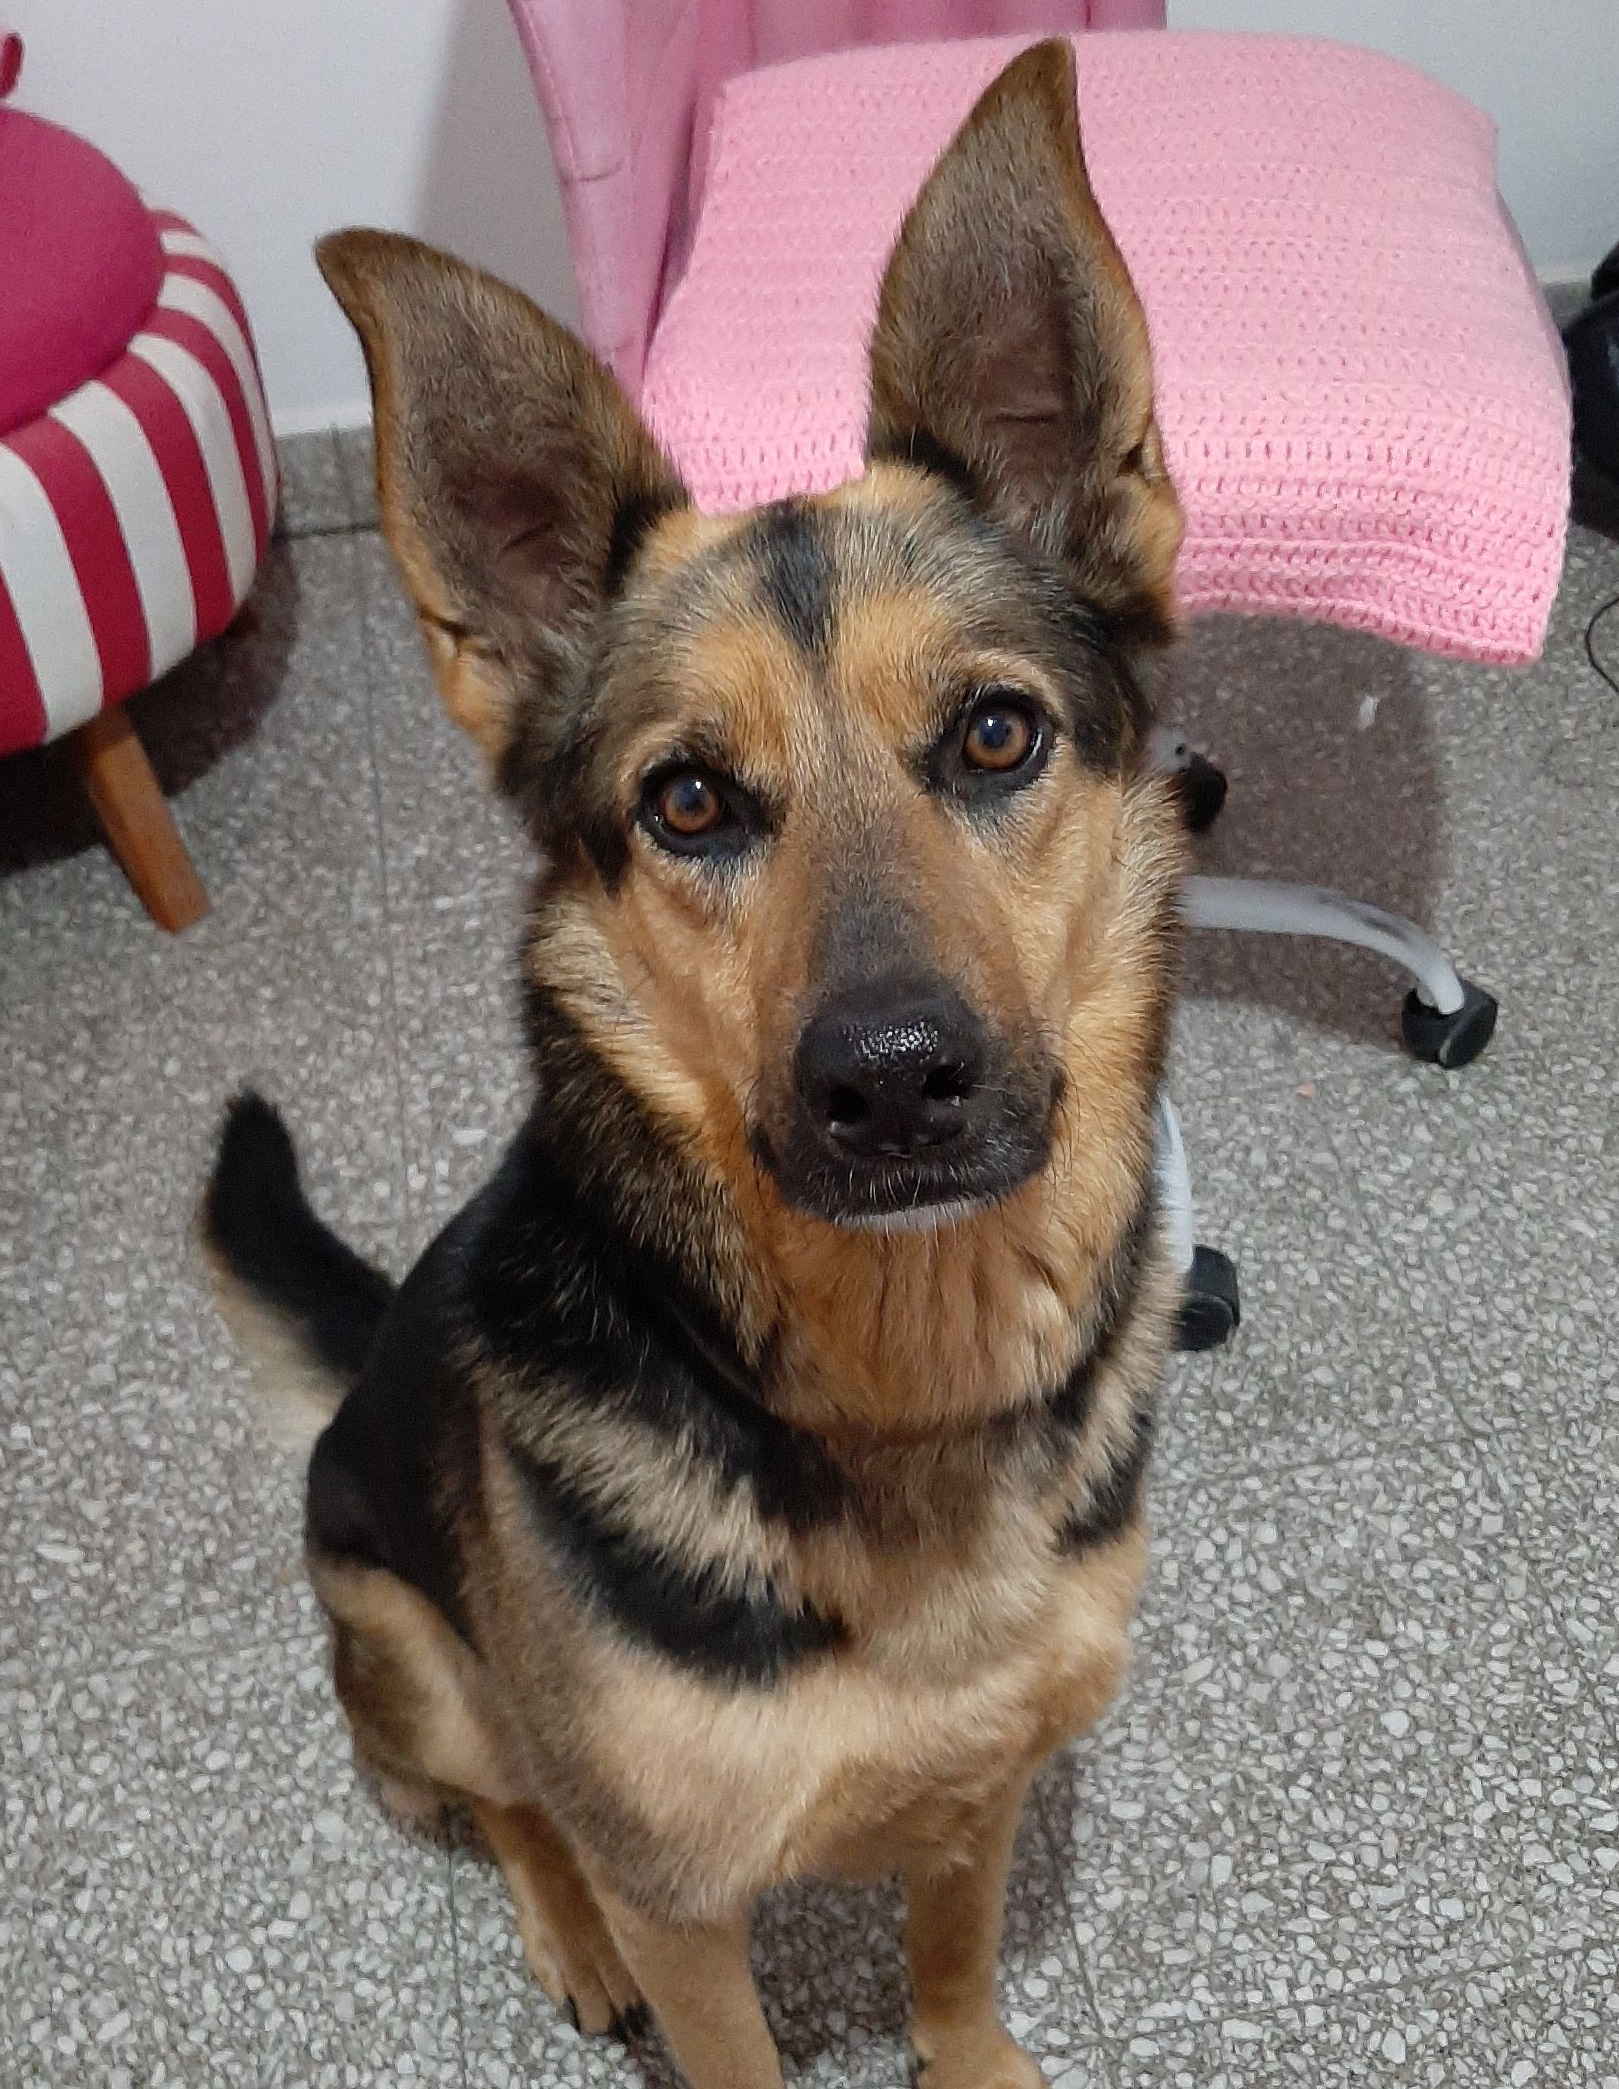

Prediction: dogs
Prediction detail: [[0.3207407  0.67925924]]


In [32]:
show_and_predict(model_mlp_2,"./Fotos/oli1.jpeg")

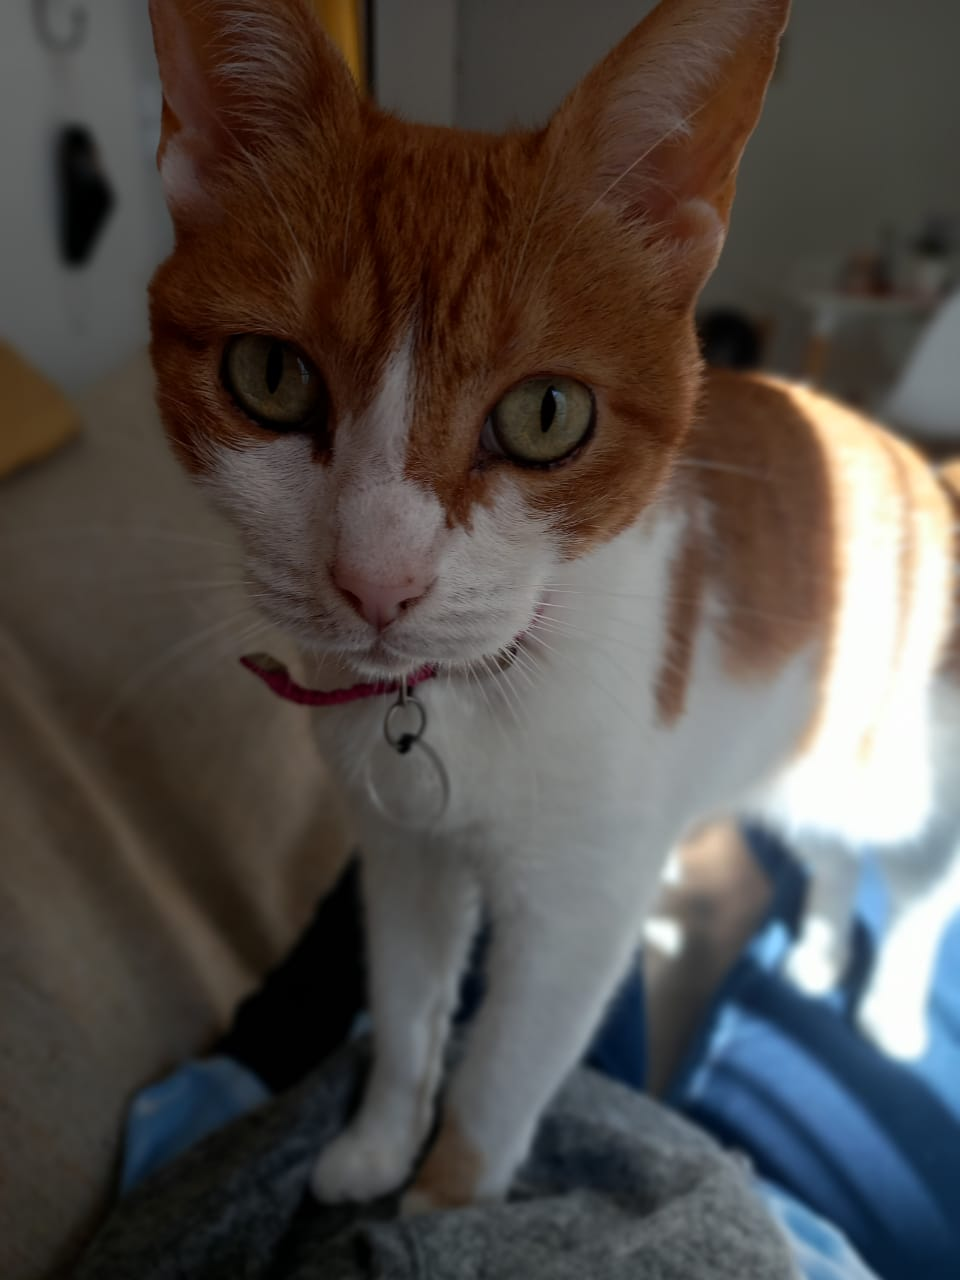

Prediction: dogs
Prediction detail: [[0.355267 0.644733]]


In [33]:
show_and_predict(model_mlp_2,"./Fotos/venus1.jpg")

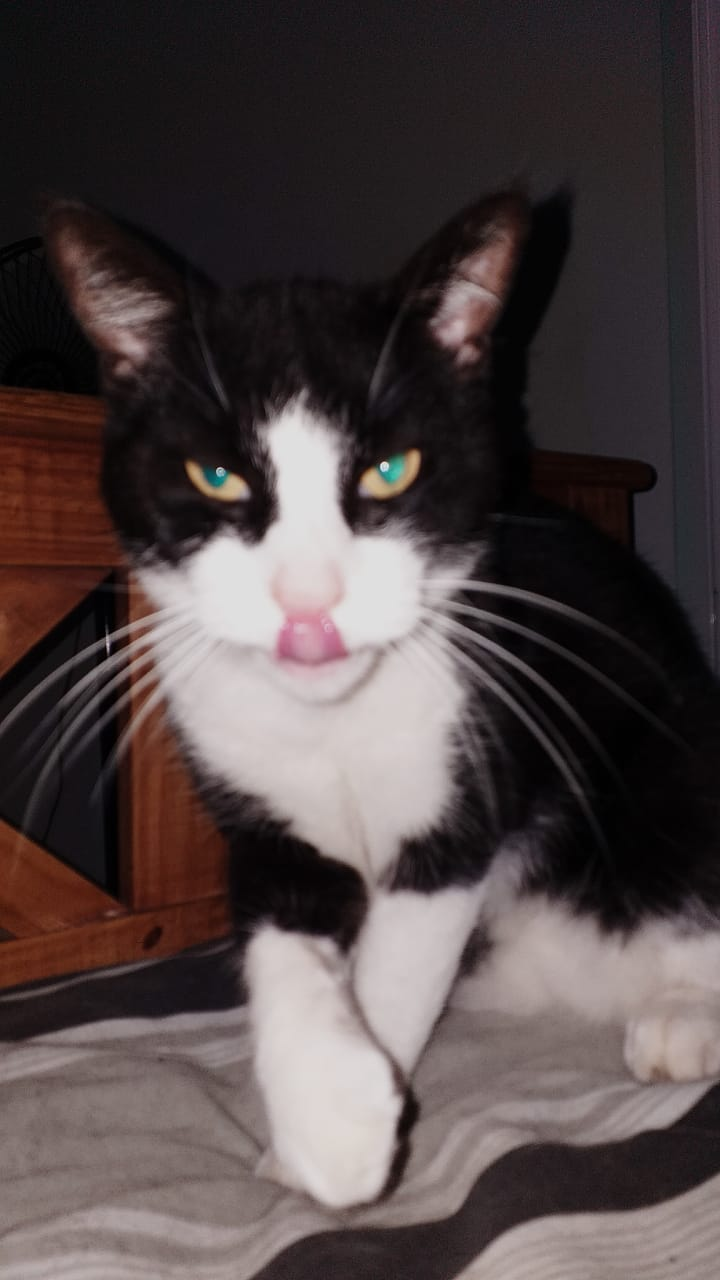

Prediction: cats
Prediction detail: [[0.9487552  0.05124483]]


In [34]:
show_and_predict(model_mlp_2,"./Fotos/negro.jpeg")

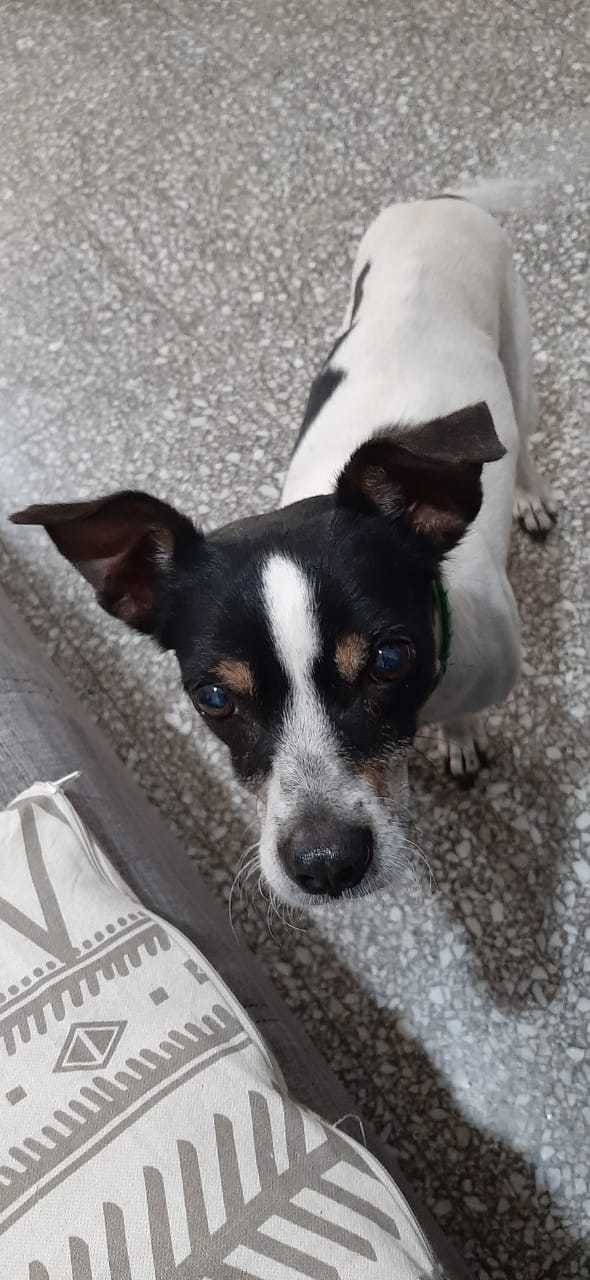

Prediction: dogs
Prediction detail: [[0.1099686 0.8900314]]


In [35]:
show_and_predict(model_mlp_2,"./Fotos/toto1.jpeg")

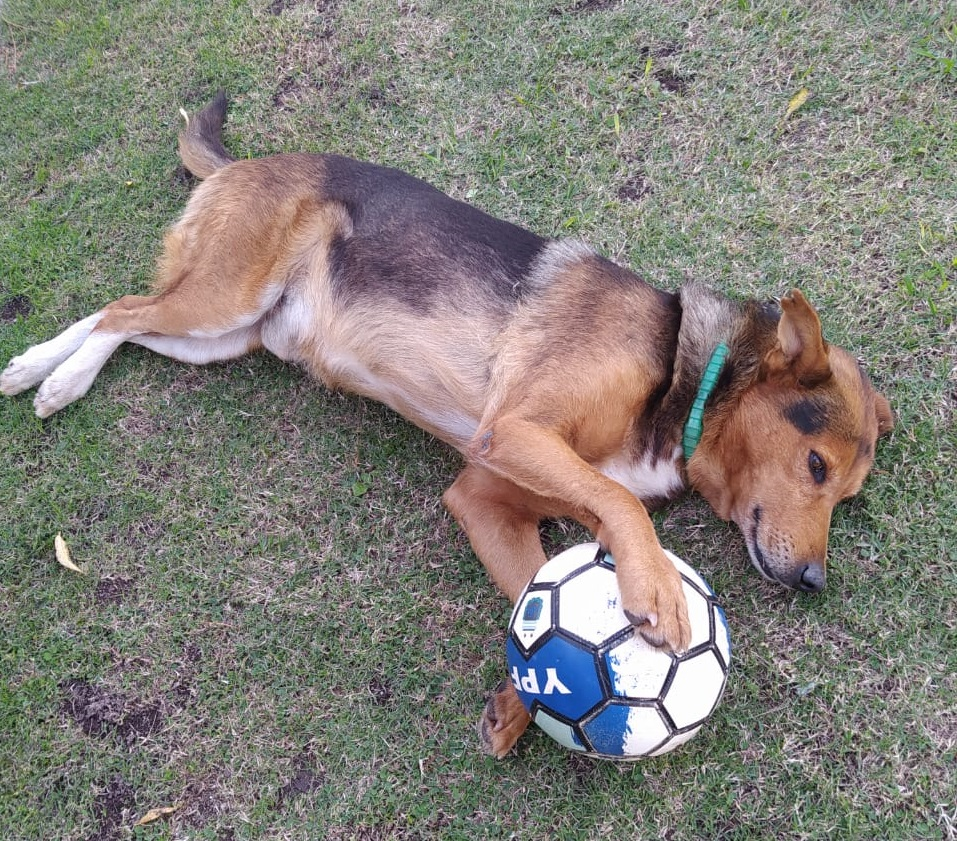

Prediction: dogs
Prediction detail: [[0.08066193 0.9193381 ]]


In [36]:
show_and_predict(model_mlp_2,"./Fotos/cacho.jpg")

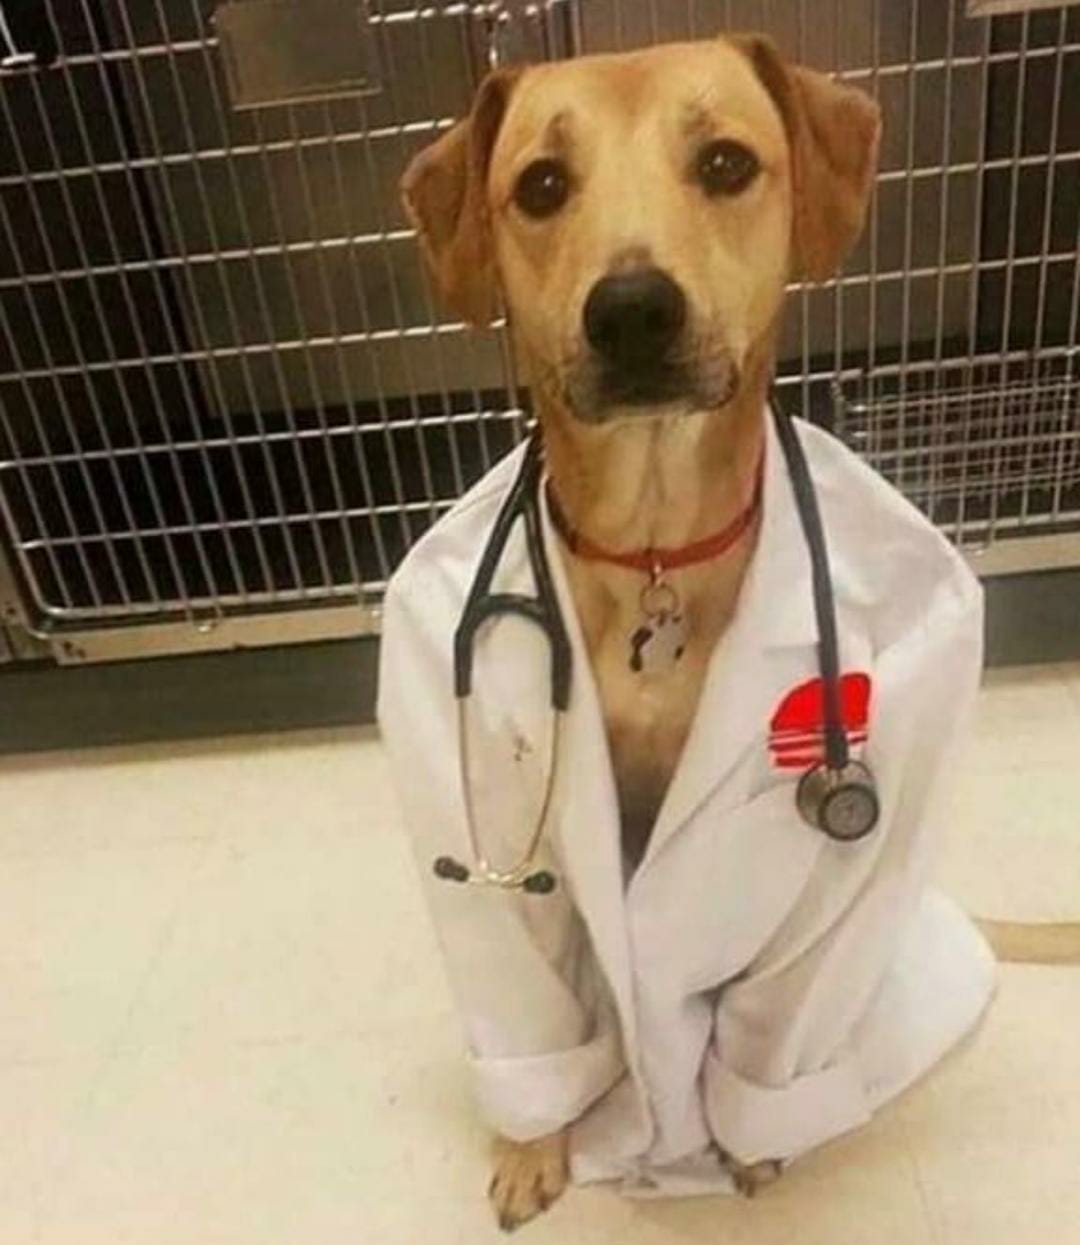

Prediction: dogs
Prediction detail: [[0.44840965 0.5515903 ]]


In [37]:
show_and_predict(model_mlp_2,"./Fotos/dogtor.jpeg")

### CNN
El mejor modelo que constuimos de CNN es el **model_cnn2**, donde obtuvimos un 73 % en test.
A continuación realizamos predicciones sobre nuevos casos:

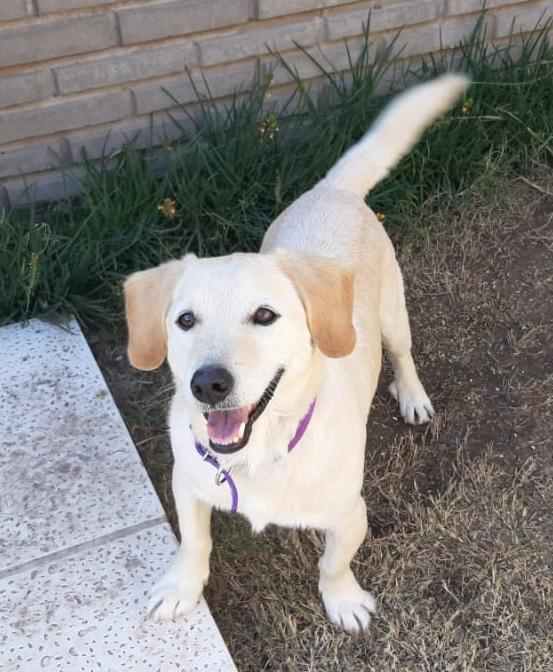

Prediction: dogs
Prediction detail: [[0.2516728 0.7483272]]


In [46]:
show_and_predict(model_cnn2,"./Fotos/beto.jpg")

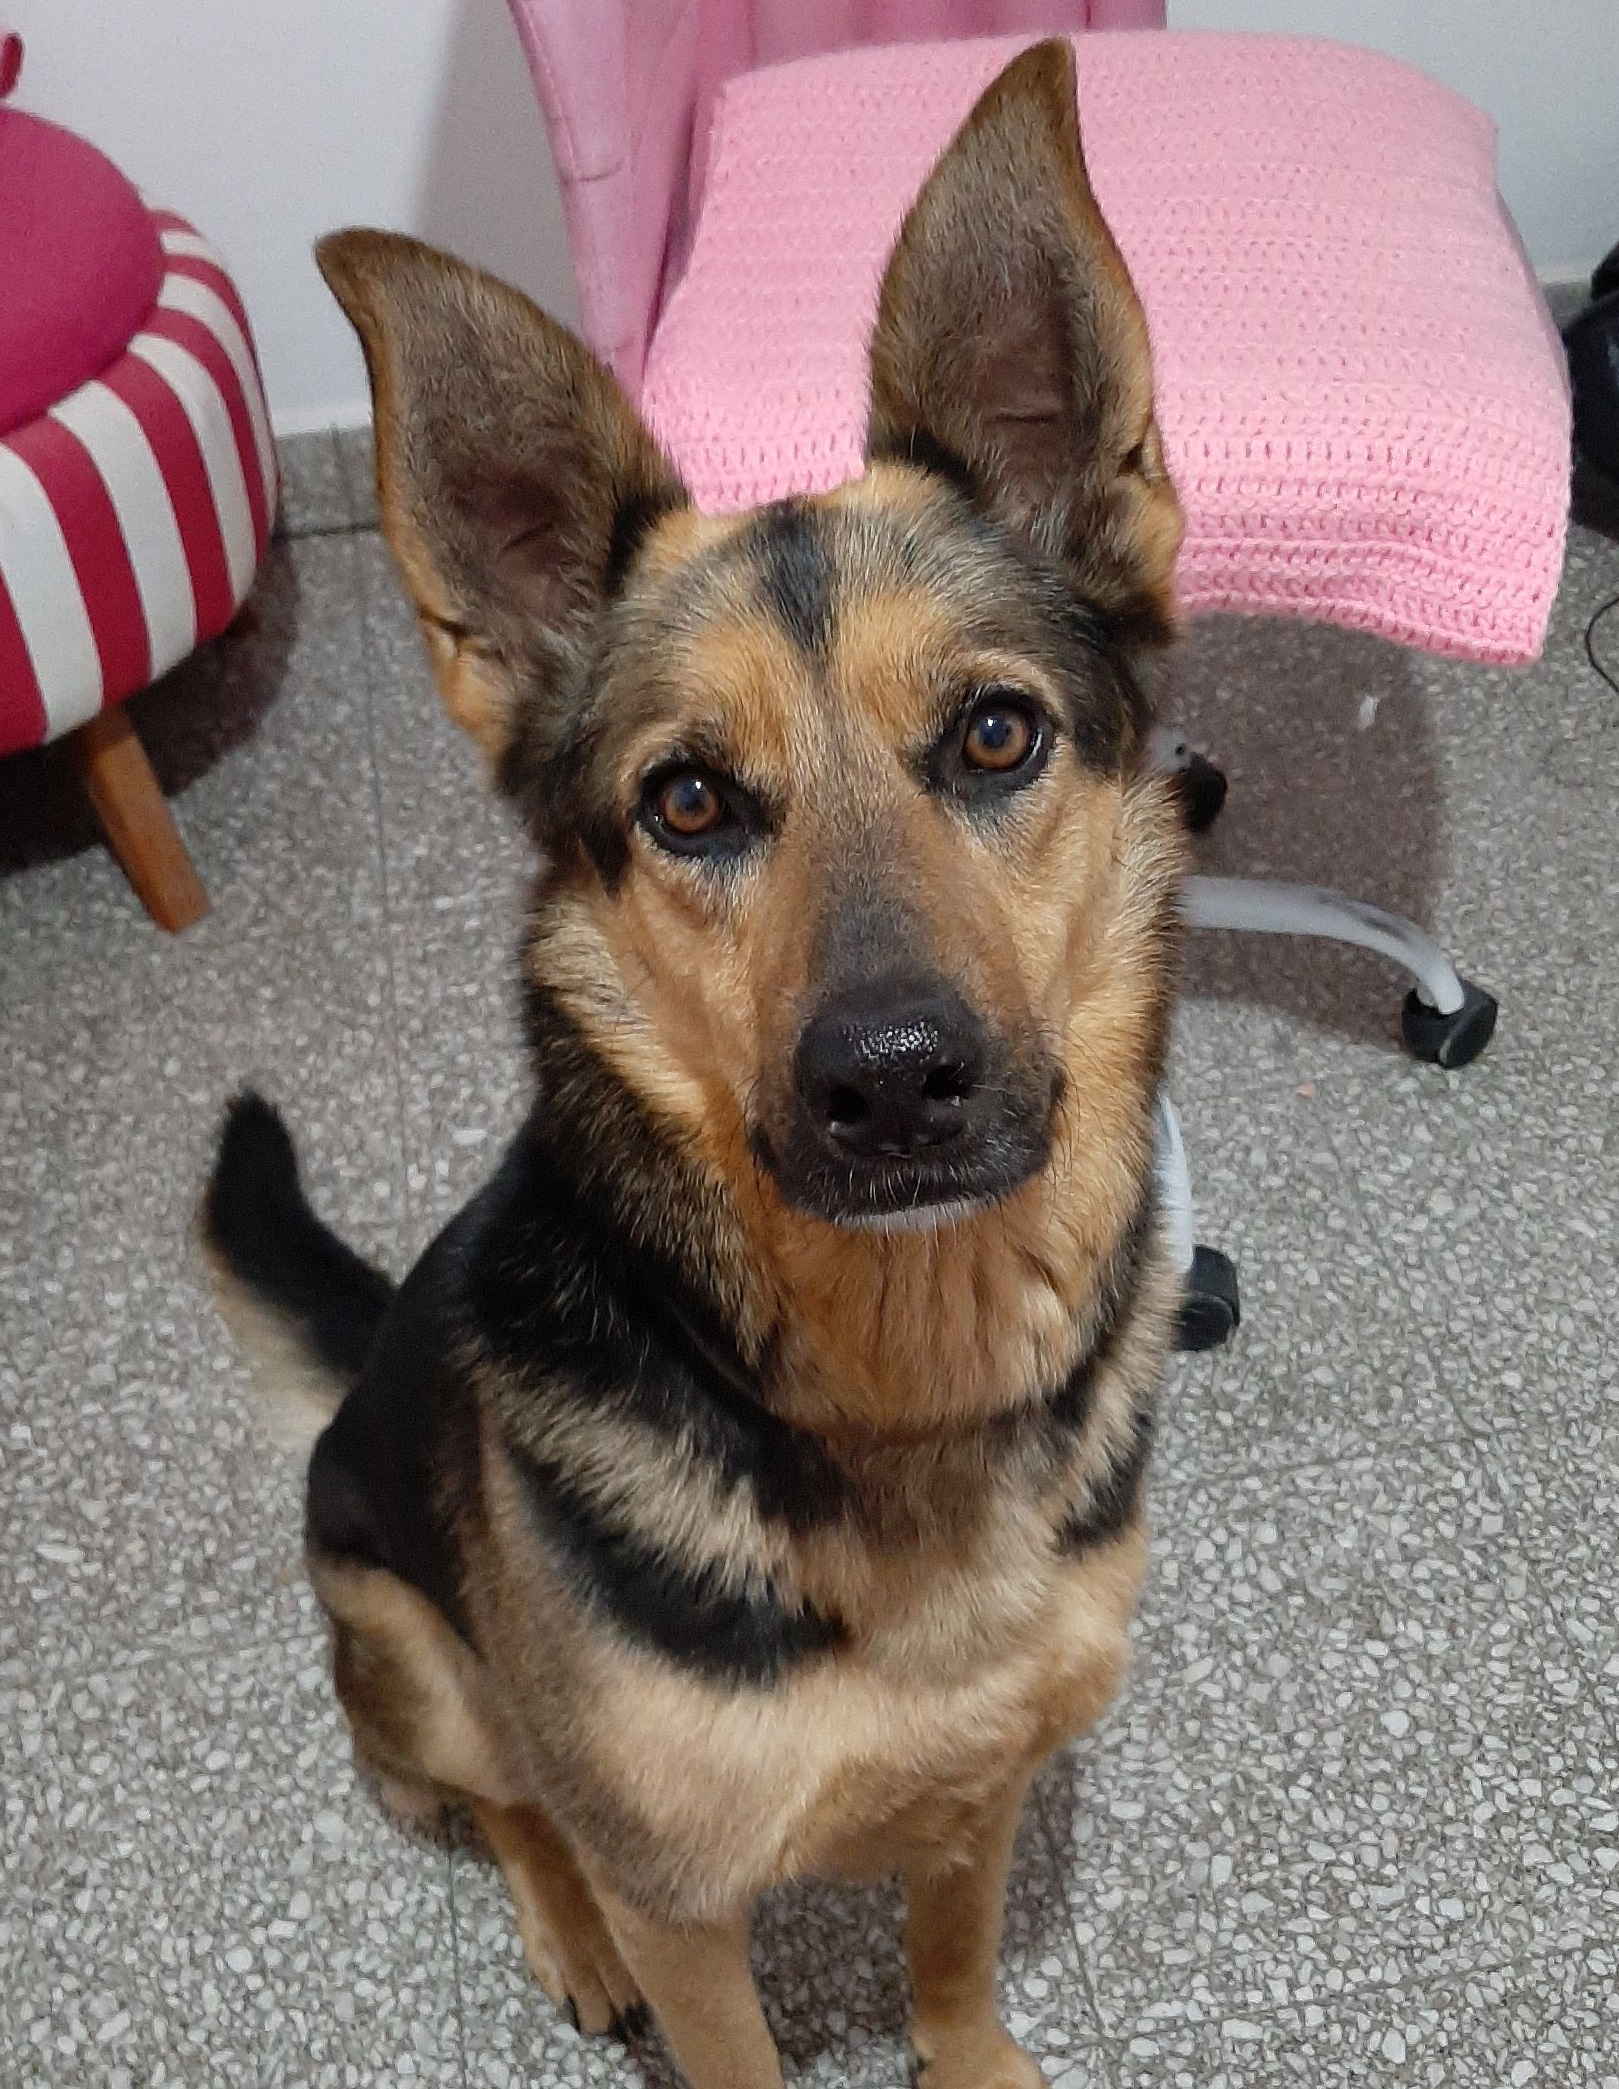

Prediction: dogs
Prediction detail: [[0.22811222 0.7718878 ]]


In [47]:
show_and_predict(model_cnn2,"./Fotos/oli1.jpeg")

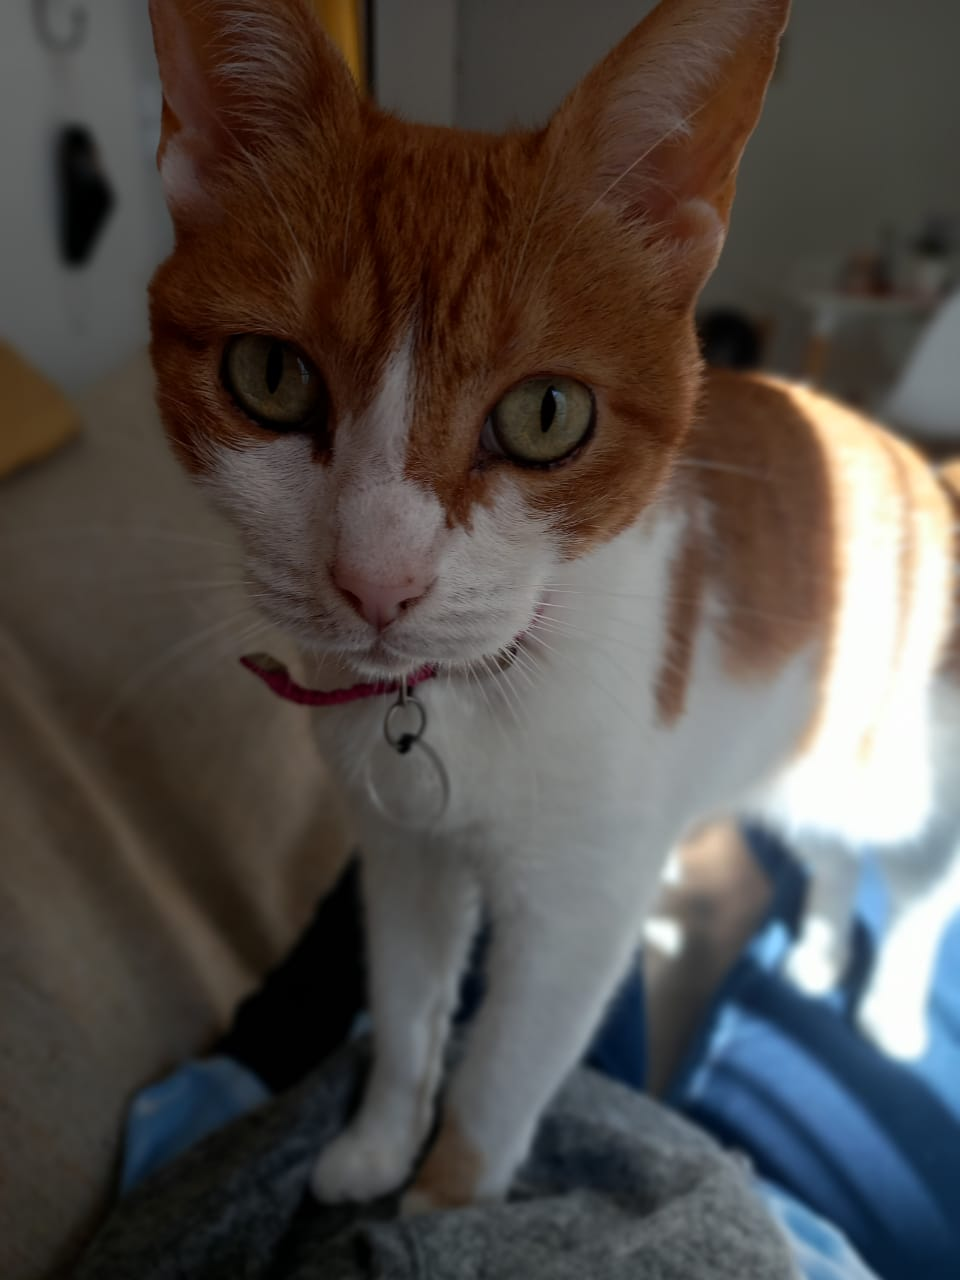

Prediction: cats
Prediction detail: [[0.8589606  0.14103936]]


In [48]:
show_and_predict(model_cnn2,"./Fotos/venus1.jpg")

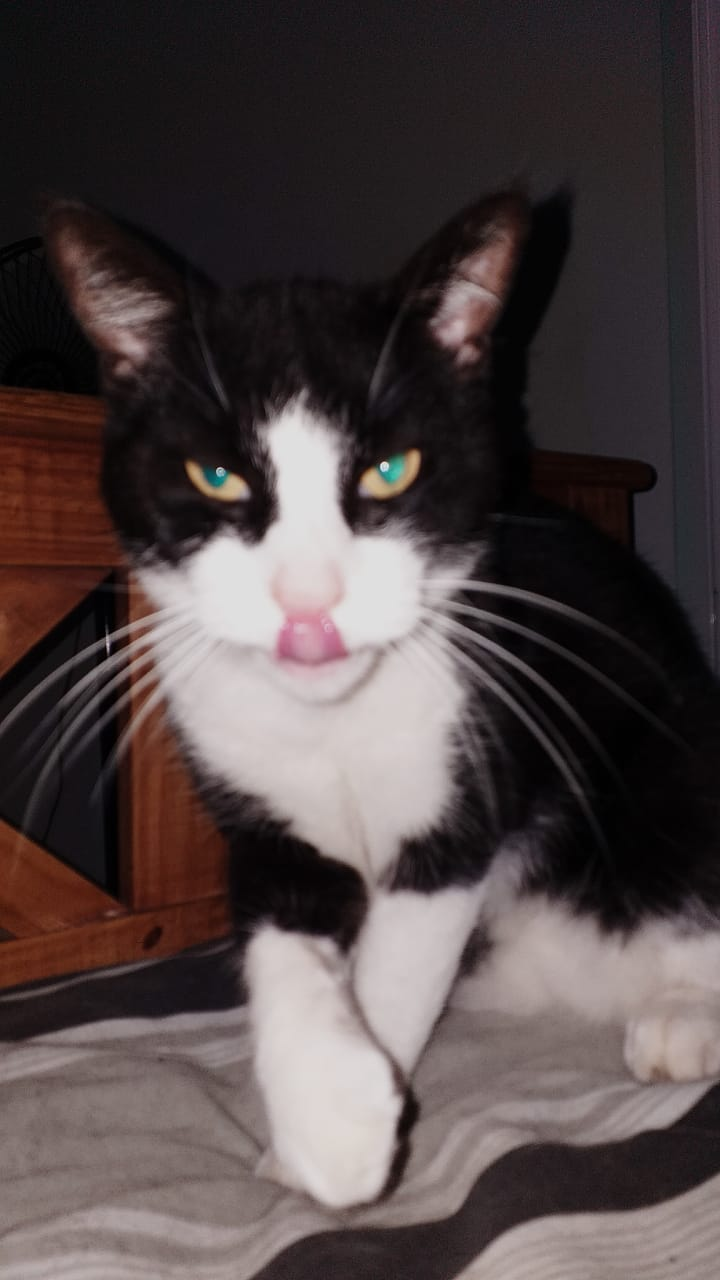

Prediction: cats
Prediction detail: [[0.9884437  0.01155637]]


In [49]:
show_and_predict(model_cnn2,"./Fotos/negro.jpeg")

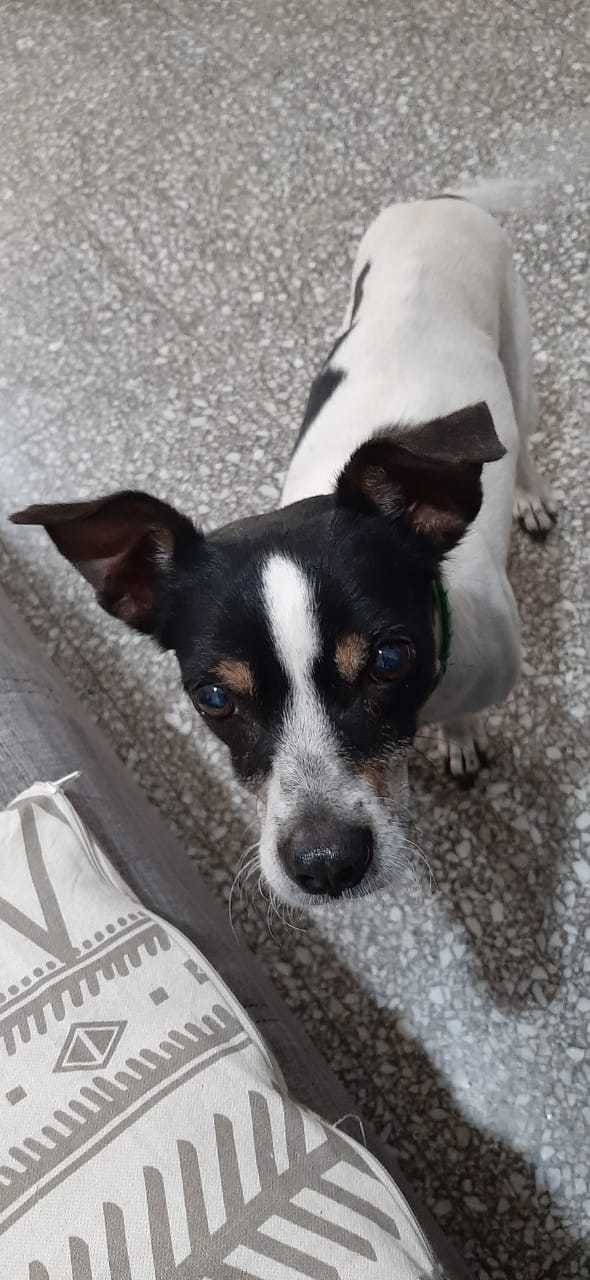

Prediction: dogs
Prediction detail: [[0.01349331 0.9865067 ]]


In [50]:
show_and_predict(model_cnn2,"./Fotos/toto1.jpeg")

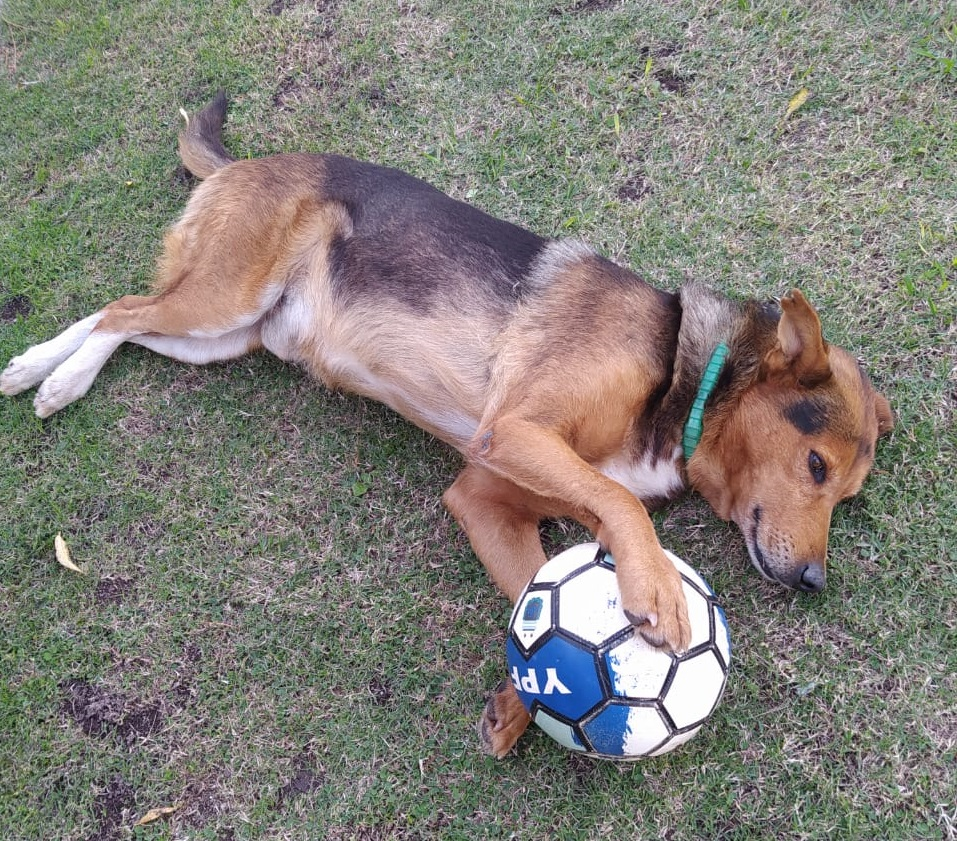

Prediction: dogs
Prediction detail: [[0.0129926 0.9870073]]


In [51]:
show_and_predict(model_cnn2,"./Fotos/cacho.jpg")

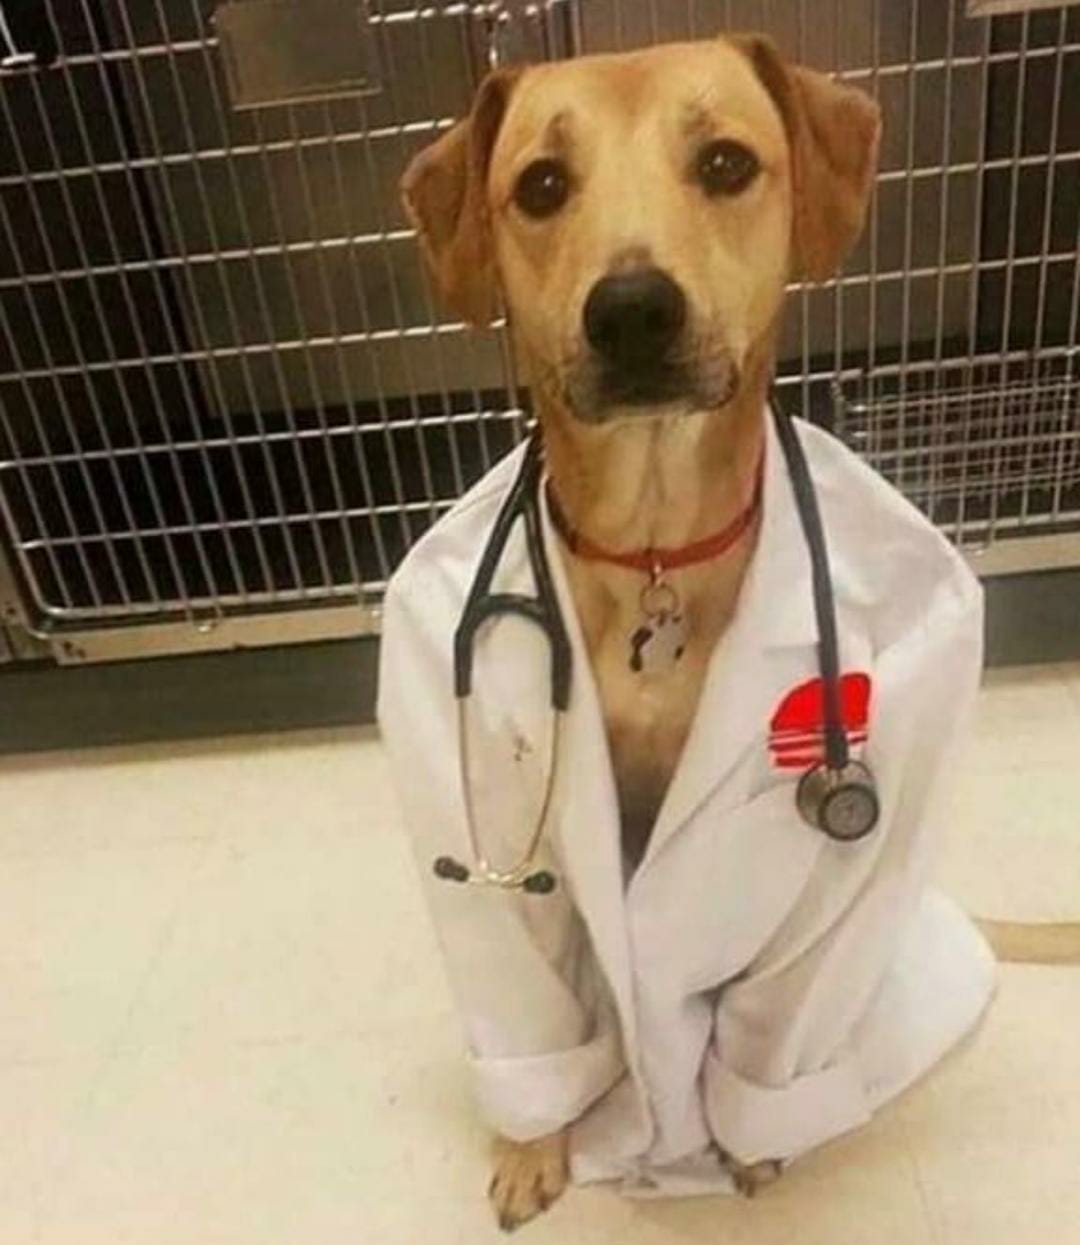

Prediction: cats
Prediction detail: [[0.5870343  0.41296571]]


In [52]:
show_and_predict(model_cnn2,"./Fotos/dogtor.jpeg")

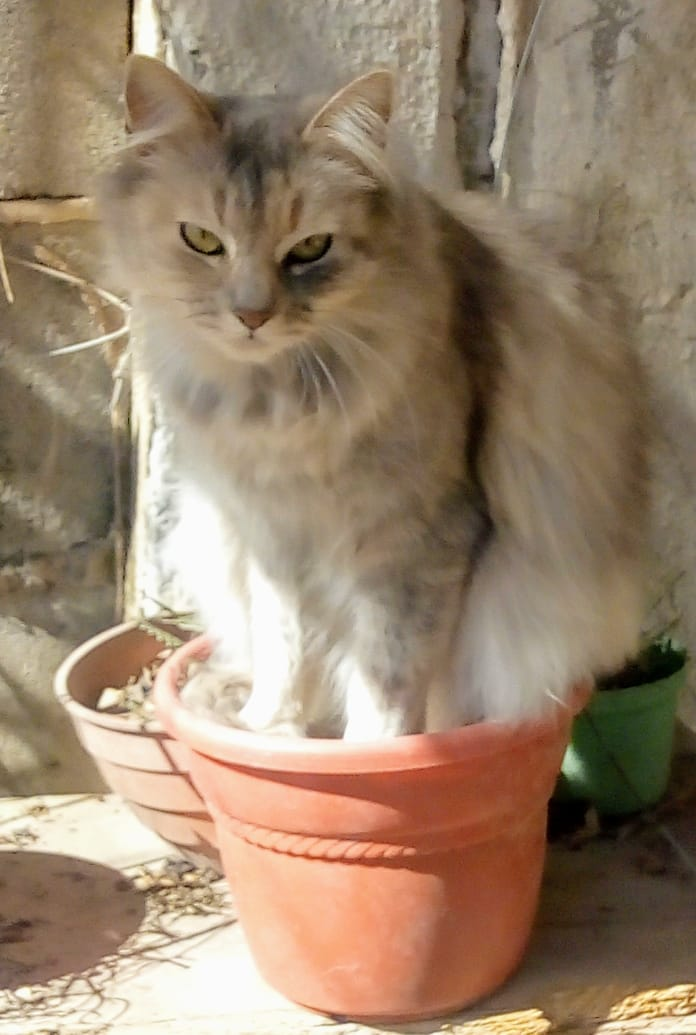

Prediction: cats
Prediction detail: [[0.5161848  0.48381522]]


In [53]:
show_and_predict(model_cnn2,"./Fotos/nina.jpeg")

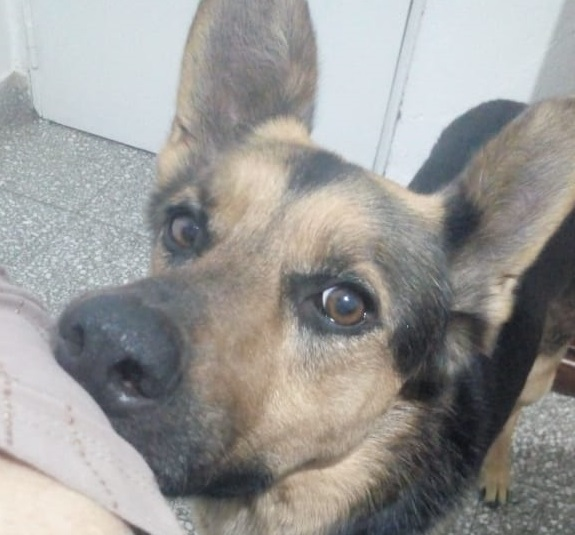

Prediction: cats
Prediction detail: [[0.89614344 0.10385653]]


In [54]:
show_and_predict(model_cnn2,"./Fotos/oli4.jpg")

Evaluando los resultados de ambos modelos obtuvimos que las **redes convolucionales** devolvieron mejores resultados en las predicciones realizadas.

## Posibles mejoras

- Entrenar los modelos con mas épocas y/o probar con otras combinaciones de capas y neuronas.
- Utilizar clases como ImageDataGenerator para alterar las imagenes aplicandole zoom o rotandolas en el dataset de train.